In [2]:
%pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import math
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Functions to collect information 

In [4]:
def get_fitness_avg(model):
    agent_fitness = [agent.fitness for agent in model.schedule.agents if isinstance(agent, Cell)]
    return np.mean(agent_fitness) if agent_fitness else 0

def get_fitness_std(model):
    agent_fitness = [agent.fitness for agent in model.schedule.agents if isinstance(agent, Cell)]
    return np.std(agent_fitness) if agent_fitness else 0

def get_life_avg(model):
    agent_lives = [agent.time_alive for agent in model.schedule.agents if isinstance(agent, Cell)]
    return np.mean(agent_lives) if agent_lives else 0

def get_life_std(model):
    agent_lives = [agent.time_alive for agent in model.schedule.agents if isinstance(agent, Cell)]
    return np.std(agent_lives) if agent_lives else 0

def get_offspring_avg(model):
    agent_offspring = [agent.num_offspring for agent in model.schedule.agents if isinstance(agent, Cell)]
    return np.mean(agent_offspring) if agent_offspring else 0

def get_offspring_std(model):
    agent_offspring = [agent.num_offspring for agent in model.schedule.agents if isinstance(agent, Cell)]
    return np.std(agent_offspring) if agent_offspring else 0

def get_fertility_avg(model):
    agent_fertility = [agent.fertility for agent in model.schedule.agents if isinstance(agent, Cell)]
    return np.mean(agent_fertility) if agent_fertility else 0

def get_fertility_std(model):
    agent_fertility = [agent.fertility for agent in model.schedule.agents if isinstance(agent, Cell)]
    return np.std(agent_fertility) if agent_fertility else 0

def save_best_controller(model):
    best_fitness = -float('inf')
    best_controller = None
    for cell in model.schedule.agents:
        if isinstance(cell, Cell) and cell.fitness > best_fitness:
            best_fitness = cell.fitness
            best_controller = cell.get_controller_state()
    return best_controller

# Model 

In [5]:
# Glucose Source
class Glucose(Agent):
    def __init__(self, unique_id, model, x, y, amount_of_calories):
        super().__init__(unique_id, model)
        self.pos = (x, y)
        self.amount_of_calories = amount_of_calories


# Toxins
class ToxinZone(Agent):
    def __init__(self, unique_id, model, x, y, radius, intensity):
        super().__init__(unique_id, model)
        self.pos = (x, y)
        self.radius = radius
        self.intensity = intensity
        self.relative_intensity = 0


    def affects_cell(self, cell):
        distance = math.sqrt((self.pos[0] - cell.pos[0]) ** 2 + (self.pos[1] - cell.pos[1]) ** 2)
        self.relative_intensity =  self.intensity

        return distance <= self.radius


# Light Source
class LightSource(Agent):
    def __init__(self, unique_id, model, x, y, radious, intensity):
        super().__init__(unique_id, model)
        self.pos = (x, y)
        self.radious = radious
        self.intensity = intensity
        self.relative_intensity = 0

    def affects_cell(self, cell):
        # Calcula la distancia entre la fuente de luz y la célula usando distancia Euclidiana
        distance = math.sqrt((self.pos[0] - cell.pos[0]) ** 2 + (self.pos[1] - cell.pos[1]) ** 2)
        # Verifica si la célula está dentro del radio de acción
        # The maximum intensity a cell can receive is the value of intensity
        self.relative_intensity =  self.intensity
        return distance <= self.radious


# Extreme PH zone
class ExtremePH(Agent):
    def __init__(self, unique_id, model, x, y, radious, intensity):
        super().__init__(unique_id, model)
        self.pos = (x, y)
        self.radious = radious
        self.intensity = intensity
        self.relative_intensity = 0

    def affects_cell(self, cell):
        distance = math.sqrt((self.pos[0] - cell.pos[0]) ** 2 + (self.pos[1] - cell.pos[1]) ** 2)
        self.relative_intensity =  self.intensity * (self.radious/(distance + self.radious))

        return distance <= self.radious

## Feedforward Neural Network Controller 

In [6]:
class Feedforward():
    def __init__(self, layer_sizes, initial_weights=None):
        # Layer sizes is a vector which represent the size of each layer
        self.weights = []

        # Here specific weights are initialisized
        if initial_weights:
            self.weights = initial_weights
        else:
            # Here random weights are initialisized
            for i in range(len(layer_sizes) - 1):
                # Small values
                weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.1
                self.weights.append(weight_matrix)

    def output(self, inputs):
        # This function calculates the output of the network
        # Through the dot product of the weights and the state of each neuron

        current_layer_output = inputs
        for weight_matrix in self.weights:
            current_layer_output = np.dot(current_layer_output, weight_matrix)
        return current_layer_output


## Two-component Regulatory System Controller

In [7]:
class TCRS:
    def __init__(self, layer_sizes, initial_weights=None):
        self.layer_sizes = layer_sizes
        if initial_weights is not None:
            # Initial weights and layers sizes represent two layers, inputs and outputs
            self.sensor_weights = np.array(initial_weights[0])
            self.output_weights = np.array(initial_weights[1])
        else:
            # Initialisize with small random weights
            self.sensor_weights = np.random.randn(layer_sizes[0]) * 0.1
            self.output_weights = np.random.randn(layer_sizes[1]) * 0.1
        self.sensor_state = 0

        self.weights = [self.sensor_weights, self.output_weights]


    def sense(self, inputs):
        self.sensor_state = np.tanh(np.dot(inputs, self.sensor_weights))
        #print("self.sensor_state:", self.sensor_state)


    def regulate(self):
        e_x = np.exp(self.sensor_state * self.output_weights)
        #print("e_x:", e_x)
        return e_x / e_x.sum()


## Cells

In [8]:
# Cellular Agent
class Cell(Agent):
    def __init__(self, unique_id, model, x, y, layer_sizes, mutation_rate_cells, controller, controller_state=None):
        super().__init__(unique_id, model)
        self.pos = (x,y)
        self.basal_metabolism = 2800
        self.calories = 3000
        self.fertility = 0
        self.toxins_disable_fertility = [False, 0]
        self.age = 0
        self.num_offspring = 0
        self.entropy = 10
        self.living = True
        self.fitness = 0
        self.max_entropy = 200
        self.time_alive = 0
        self.toxin_input = 0
        self.extreme_ph_input = 0
        self.light_input = 0
        self.glucose_input = 0
        self.mutation_rate_cells = mutation_rate_cells
        self.controller_state = controller_state
        self.layer_sizes = layer_sizes
        self.controller = controller
        self.neural_network = None
        self.TCRS_controller = None

    # Feedforward network or TCRS as a controller
    # Controller states assigns specific weights for the cell controller
    # Comment or discomment depending on what controller you want do use

        if self.controller == "TCRS":
                if controller_state != None:
                        self.TCRS_controller = TCRS(self.layer_sizes, controller_state)
                else:
                        self.TCRS_controller = TCRS(self.layer_sizes)
        else:
                if controller_state != None:
                    self.neural_network = Feedforward(self.layer_sizes, controller_state)
                else:
                    self.neural_network = Feedforward(self.layer_sizes)




    # Storing the controller of the cell
    def get_controller_state(self):
        return  self.TCRS_controller.weights if self.TCRS_controller != None else self.neural_network.weights


    def reproduce(self):
        # Create a new cell with the same properties
        child = Cell(self.model.next_id(), self.model, self.pos[0], self.pos[1], self.layer_sizes, self.mutation_rate_cells, self.controller)
        child.mutate()  # Apply mutations to the child
        return child


    def mutate(self):
        # For feedforward neural network
        mutation_rate = self.mutation_rate_cells  # Probability of mutation per weight
        mutation_strength = 0.12  # Magnitude of mutation

        if self.controller != "TCRS":
            for i in range(len(self.neural_network.weights)):
                if np.random.rand() < mutation_rate:
                    # Apply mutation as a random normal perturbation to the weights
                    noise = np.random.normal(0, mutation_strength, self.neural_network.weights[i].shape)
                    self.neural_network.weights[i] += noise
        else:
            for i in range(len(self.TCRS_controller.weights)):
                if np.random.rand() < mutation_rate:
                    # Apply mutation as a random normal perturbation to the weights
                    noise = np.random.normal(0, mutation_strength, self.TCRS_controller.weights[i].shape)
                    self.TCRS_controller.weights[i] += noise


    def is_fertil(self):
        # Habilita o deshabilita la fertilidad basada en la entropía y las calorías
        if (self.entropy > 50 and self.entropy < 180) and (self.calories > 800):
            self.fertility = 1
        else:
            self.fertility = 0



    def asexual_reproduction(self):
        self.entropy += 35
        self.calories -= 400
        self.num_offspring += 1


    def increase_entropy(self):
        # Entropy as the relationship between amount of calories needed for conserving its structure versus
        # the amount of calories the cell is able to obtain

        self.entropy += (self.basal_metabolism / (self.calories + 0.1))


    def toxins_fertility(self):
        if self.toxins_disable_fertility[0]:  # Si la fertilidad está deshabilitada
            time_disabled = self.time_alive - self.toxins_disable_fertility[1]
            if time_disabled >= 15:  # Si han pasado 15 o más pasos
                self.toxins_disable_fertility = [False, 0]
                self.fertility = 1  # Reactiva la fertilidad
            else:
                pass



    def check_toxin_zones(self):
        toxin_zones = [agent for agent in self.model.schedule.agents if isinstance(agent, ToxinZone)]

        # Check if cell is infected by toxins
        for zone in toxin_zones:
            if zone.affects_cell(self):
                if self.fertility == 1:
                    self.fertility = 0  # Cell loses reproduction capacity if is in toxin zone
                    self.toxins_disable_fertility = [True, self.time_alive]


                self.entropy  += zone.relative_intensity # Increasing entropy simulating stress due to toxin
                self.calories -= zone.relative_intensity # Spending energy to deal with toxin
                self.toxin_input = zone.relative_intensity # Senses toxin intensity

               # print("Entropy increasing due to Toxins")
                #print("Calories decreasing due to Toxins")


    def check_extreme_ph_zones(self):
        extreme_ph_zones = [agent for agent in self.model.schedule.agents if isinstance(agent, ExtremePH)]
        for zone in extreme_ph_zones:
            if zone.affects_cell(self):
                self.entropy += zone.relative_intensity # Velocity decreases
                self.extreme_ph_input = zone.relative_intensity # Senses PH intensity (acid or alkaline)
                #print("Self Speed has been change due to PH extreme zone")




    def check_light_sources(self):
        light_sources = [agent for agent in self.model.schedule.agents if isinstance(agent, LightSource)]
        for light in light_sources:
            if light.affects_cell(self):
                self.calories += light.relative_intensity  # Receive the amount of calories for the light
                self.light_input = light.relative_intensity # Senses the light intensity
                #print("Light Source giving some energy")
            else:
                pass


    def check_and_consume_glucose(self):
        # Check if there's glucose in the position
        contents = self.model.grid.get_cell_list_contents([self.pos])
        glucose_list = [obj for obj in contents if isinstance(obj, Glucose)]
        if len(glucose_list) > 0:
            # if so, sense the input, get the calories and remove the Glucose object
            for glucose in glucose_list:
                self.calories += glucose.amount_of_calories
                self.glucose_input = 1
                #print("Receiving Energy From Glucose")
                self.model.grid.remove_agent(glucose)
                self.model.schedule.remove(glucose)
        else:
            # Otherwise, the stimulus of glucose is 0
            self.glucose_input = 0


    def move(self, direction):
        # New position based on the direction
        delta = [(0, 1), (0, -1), (-1, 0), (1, 0)]  # Up, down, left, right
        new_x = self.pos[0] + delta[direction][0]
        new_y = self.pos[1] + delta[direction][1]

        # Check movement inside the world
        if 0 <= new_x < self.model.grid.width and 0 <= new_y < self.model.grid.height:
            # Comprueba si el agente aún está en la celda original antes de moverlo
            if self in self.model.grid.get_cell_list_contents([self.pos]):
                self.model.grid.move_agent(self, (new_x, new_y))



    def die(self):
        #if entropy is more than an specific limit, the cell dies
        if  self.entropy > self.max_entropy:
            self.living = False



    def fitness_measurement(self):
        weight_time_alive = 1
        weight_num_offsprings = 30
        #print("self fitness:", self.fitness)
        self.fitness = (weight_time_alive*self.time_alive) +  (weight_num_offsprings*self.num_offspring)



    def step(self):
        if self.living:
            self.check_toxin_zones()
            self.toxins_fertility()
            self.is_fertil()  # Updating fertility if is not in toxins zones
            self.check_extreme_ph_zones()
            self.check_light_sources()
            self.check_and_consume_glucose()

            # Inputs sensed by the cell
            inputs = np.array([self.glucose_input, self.light_input, self.extreme_ph_input, self.toxin_input, self.calories, self.entropy])

            if self.controller != "TCRS":
                # Feedforward Neural Network

                outputs = self.neural_network.output(inputs)
                move_direction = np.argmax(outputs[:4])  # Action based on the output of the network
                if outputs[move_direction] > 0.5:
                    self.move(move_direction)
                if outputs[4] > 0.5 and self.fertility:  # Decision of reproduction
                    self.asexual_reproduction()
            else:
                # Two Component Regulatory System
                self.TCRS_controller.sense(inputs)  # Receive signals from the environment
                outputs = self.TCRS_controller.regulate()  # Actions based on the output of the system

                # Choose based on the highest probability
                move_direction = np.argmax(outputs)

                #print("move direction:", move_direction)

                # Actions
                if move_direction < 4:
                    self.move(move_direction)
                elif move_direction == 4 and self.fertility:
                    self.asexual_reproduction()

            self.increase_entropy()
            self.time_alive += 1
            self.fitness_measurement()
            self.die()


## Environment

In [9]:
class CellEnvironment(Model):
    def __init__(self, num_cells, num_food, num_light_sources, num_extreme_ph_zones, num_toxin_zones,
                 mutation_rate_cells, controller_state=None):
        super().__init__()
        width = 100
        height = 100
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
                    model_reporters={
                        "Average Fitness": get_fitness_avg,
                        "Fitness Std Dev": get_fitness_std,
                        "Average Lifespan": get_life_avg,
                        "Lifespan Std Dev": get_life_std,
                        "Average Offspring": get_offspring_avg,
                        "Offspring Std Dev": get_offspring_std,
                        "Average Fertility": get_fertility_avg,
                        "Fertility Std Dev": get_fertility_std
                    }
                )


               # Creating toxins
        for i in range(num_toxin_zones):
            x = self.random.randrange(0, 99)
            y = 0
            radius = self.random.randrange(5, 15)
            intensity = 1
            toxin_zone = ToxinZone(self.next_id() + i + 4000, self, x, y, radius, intensity)
            self.grid.place_agent(toxin_zone, (x, y))
            self.schedule.add(toxin_zone)



        # Creating extreme PH zones
        for i in range(num_extreme_ph_zones):
            x = self.random.randrange(0, 99)
            y = -5
            radious = 20
            intensity = 30
            extreme_ph_zone = ExtremePH(self.next_id() + i + 3000, self, x, y, radious, intensity)
            self.grid.place_agent(extreme_ph_zone, (x, y))
            self.schedule.add(extreme_ph_zone)


         # Creating light sources
        for i in range(num_light_sources):
            x = 10
            y = self.random.randrange(10, 90)
            #intensity = self.random.uniform(0, 0.9)
            intensity = 2
            radious = 15
            light_source = LightSource(self.next_id() + i + 2000, self, x, y, radious, intensity)
            self.grid.place_agent(light_source, (x, y))
            self.schedule.add(light_source)


        # Creating glucose sources
        for i in range(num_food):
            x = 99
            y = self.random.randrange(10, 90)
            amount_of_calories = 25
            glucose = Glucose(self.next_id() + i+ 1000, self, x, y, amount_of_calories)
            self.grid.place_agent(glucose, (x, y))
            self.schedule.add(glucose)


        # Creating Cells
        for i in range(num_cells):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            layer_sizes = [6,5,5]
            cell = Cell(self.next_id() + i, self, x, y, layer_sizes, mutation_rate_cells, "TCRS",  controller_state=controller_state)
            self.grid.place_agent(cell, (x, y))
            self.schedule.add(cell)


    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


# Evolution

## Selection and mutation methods for the Genetic Algorithm

In [10]:
def selection_and_reproduction(model, desired_population_size):
    reproducers = [cell for cell in model.schedule.agents if isinstance(cell, Cell) and cell.num_offspring > 0]
    reproducers = sorted(reproducers, key=lambda x: (x.fitness, x.num_offspring), reverse=True)

    new_generation = []
    if not reproducers:
        return

    reproduction_rounds = max(cell.num_offspring for cell in reproducers)

    current_round = 1
    while len(new_generation) < desired_population_size:
        for cell in reproducers:
            if cell.num_offspring >= current_round:
                new_cell = cell.reproduce()
                new_generation.append(new_cell)
                if len(new_generation) == desired_population_size:
                    break
        if current_round == reproduction_rounds:
            current_round = 0
        current_round += 1

    cells_to_remove = [agent for agent in model.schedule.agents if isinstance(agent, Cell)]
    for cell in cells_to_remove:
        model.schedule.remove(cell)

    for new_agent in new_generation:
        model.schedule.add(new_agent)


## Simulation

   Vectors to store useful information ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
number_of_cells_per_generation = []

average_fitness_per_generation = []
fitness_std_per_generation = []

average_lifespan_per_generation = []
lifespan_std_per_generation = []

average_num_offspring_per_generation = []
offspring_std_per_generation = []

weight_diversities_per_generation = []


Important parameters ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
num_steps_per_generation = 300
number_of_generations = 30
num_cells = 200
num_food =  100
num_light_sources = 5
num_extreme_ph_zones = 30
num_toxin_zones = 40
mutation_rate_cells = 0.15

Simulating the model ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [13]:
# Genetic Algorithm ---------------------------------------------------------------------------------

# Problems adding multiprocessing, but it's a good idea implemented here

model = CellEnvironment(num_cells, num_food, num_light_sources, num_extreme_ph_zones, num_toxin_zones,
                        mutation_rate_cells, controller_state=None)

for generation in range(number_of_generations):

    for i in range(num_steps_per_generation):
        model.step()

    selection_and_reproduction(model, num_cells)

    print(f"Generation {generation} data:",  model.datacollector.get_model_vars_dataframe().iloc[-1])

    generation_data = model.datacollector.get_model_vars_dataframe().iloc[-1]


    # Storing useful information per generation----------------------------------------------
    number_of_cells = len([cell for cell in model.schedule.agents if isinstance(cell, Cell)])
    number_of_cells_per_generation.append(number_of_cells)
    print("amount of cells:", number_of_cells)

    average_fitness_per_generation.append(generation_data['Average Fitness'])
    fitness_std_per_generation.append(generation_data['Fitness Std Dev'])

    average_lifespan_per_generation.append(generation_data['Average Lifespan'])
    lifespan_std_per_generation.append(generation_data['Lifespan Std Dev'])

    average_num_offspring_per_generation.append(generation_data['Average Offspring'])
    offspring_std_per_generation.append(generation_data['Offspring Std Dev'])


# Storing the best controller
best_controller = save_best_controller(model)

<ipython-input-9-681be04b827e>:30: UserWarning: Agent 4001 is being placed with
place_agent() despite already having the position (12, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(toxin_zone, (x, y))
<ipython-input-9-681be04b827e>:30: UserWarning: Agent 4003 is being placed with
place_agent() despite already having the position (44, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(toxin_zone, (x, y))
<ipython-input-9-681be04b827e>:30: UserWarning: Agent 4005 is being placed with
place_agent() despite already having the position (39, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(toxin_zone, (x, y))
<ipython-input-9-681be04b827e>:30: UserWarning: Agent 4007 is being placed with
place_agent() despite already having the positi

Generation 0 data: Average Fitness      146.240000
Fitness Std Dev       81.321845
Average Lifespan     123.290000
Lifespan Std Dev      89.100819
Average Offspring      0.765000
Offspring Std Dev      1.536156
Average Fertility      0.190000
Fertility Std Dev      0.392301
Name: 299, dtype: float64
amount of cells: 200
Generation 1 data: Average Fitness      188.240000
Fitness Std Dev       52.386472
Average Lifespan     163.490000
Lifespan Std Dev      77.656036
Average Offspring      0.825000
Offspring Std Dev      1.604486
Average Fertility      0.070000
Fertility Std Dev      0.255147
Name: 599, dtype: float64
amount of cells: 200
Generation 2 data: Average Fitness      199.450000
Fitness Std Dev       22.898854
Average Lifespan     174.100000
Lifespan Std Dev      66.857685
Average Offspring      0.845000
Offspring Std Dev      1.628182
Average Fertility      0.005000
Fertility Std Dev      0.070534
Name: 899, dtype: float64
amount of cells: 200
Generation 3 data: Average Fitness

## Visualization of metrics

In [14]:
max_fitness = model.datacollector.get_model_vars_dataframe()['Average Fitness'].max()
print("The max fitness achieved is:", max_fitness)

The max fitness achieved is: 222.695


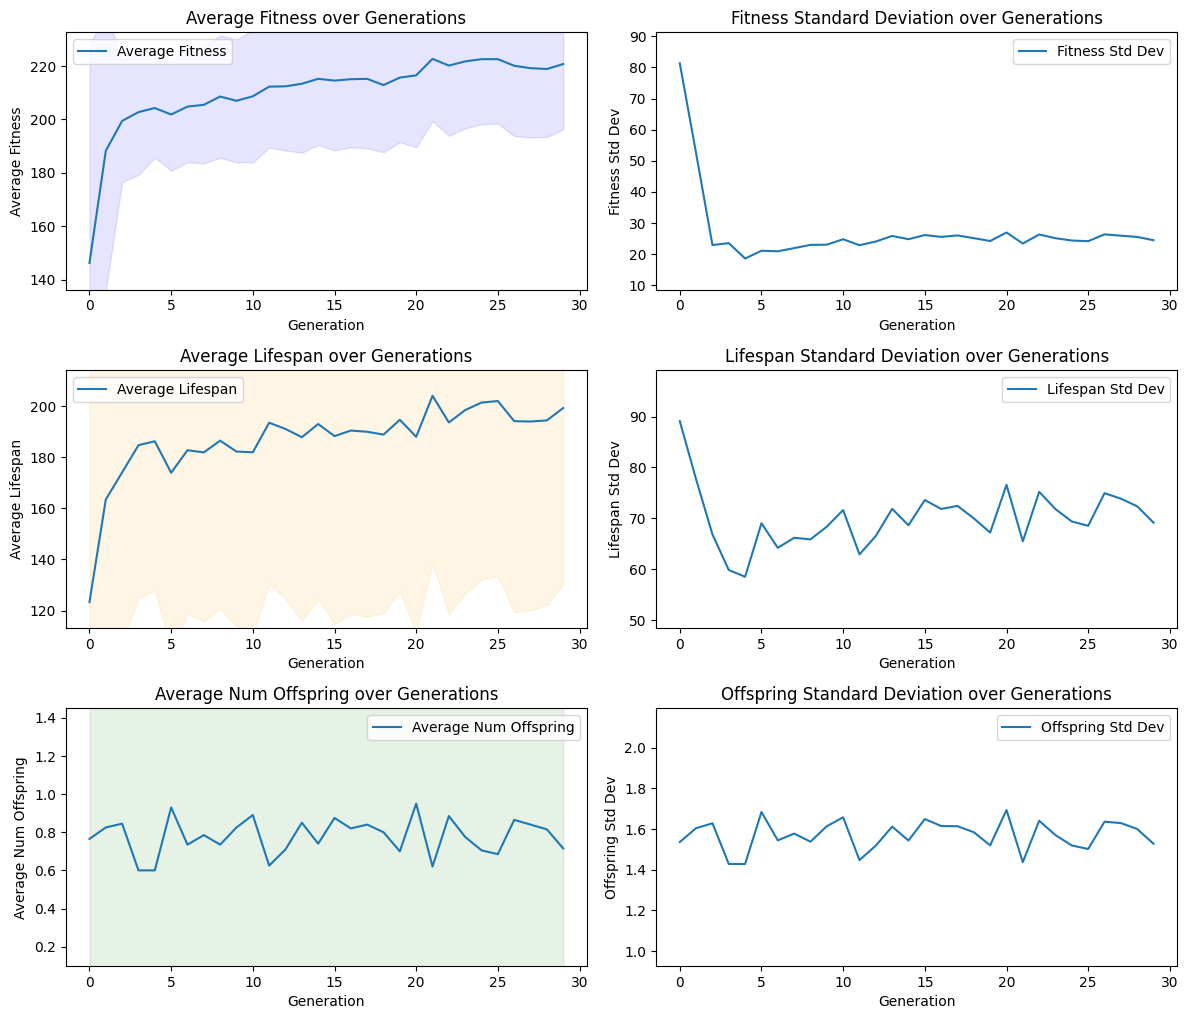

In [15]:
plt.figure(figsize=(12, 20))

generations = [i for i in range(number_of_generations)]

# Average fitness per generation
plt.subplot(6, 2, 1)  # Esto crea un subplot en una grilla de 2x2 en la posición 2
plt.plot(average_fitness_per_generation, label='Average Fitness')
plt.fill_between(range(len(fitness_std_per_generation)),
                 [a - b for a, b in zip(average_fitness_per_generation, fitness_std_per_generation)],
                 [a + b for a, b in zip(average_fitness_per_generation, fitness_std_per_generation)],
                 color='blue', alpha=0.1)
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
min_fitness = min(average_fitness_per_generation)
max_fitness = max(average_fitness_per_generation)
plt.ylim([min_fitness - 10, max_fitness  + 10])
plt.title('Average Fitness over Generations')
plt.legend()


# Average standard deviation fitness per generation
plt.subplot(6, 2, 2)
plt.plot(generations, fitness_std_per_generation, label='Fitness Std Dev')
plt.xlabel('Generation')
plt.ylabel('Fitness Std Dev')
min_fitness = min(fitness_std_per_generation)
max_fitness = max(fitness_std_per_generation)
plt.ylim([min_fitness - 10, max_fitness  + 10])
plt.title('Fitness Standard Deviation over Generations')
plt.legend()



# Average lifespan per generation
plt.subplot(6, 2, 3)  # Esto crea un subplot en una grilla de 2x2 en la posición 3
plt.plot(average_lifespan_per_generation, label='Average Lifespan')
plt.fill_between(range(len(lifespan_std_per_generation)),
                 [a - b for a, b in zip(average_lifespan_per_generation, lifespan_std_per_generation)],
                 [a + b for a, b in zip(average_lifespan_per_generation, lifespan_std_per_generation)],
                 color='orange', alpha=0.1)
plt.xlabel('Generation')
plt.ylabel('Average Lifespan')
min_fitness = min(average_lifespan_per_generation)
max_fitness = max(average_lifespan_per_generation)
plt.ylim([min_fitness - 10, max_fitness  + 10])
plt.title('Average Lifespan over Generations')
plt.legend()


# Average lifespan standard deviation per generation
plt.subplot(6, 2, 4)
plt.plot(generations, lifespan_std_per_generation, label='Lifespan Std Dev')
plt.xlabel('Generation')
plt.ylabel('Lifespan Std Dev')
min_fitness = min(lifespan_std_per_generation)
max_fitness = max(lifespan_std_per_generation)
plt.ylim([min_fitness - 10, max_fitness  + 10])
plt.title('Lifespan Standard Deviation over Generations')
plt.legend()



# Average offsprings per generation
plt.subplot(6, 2, 5)  # Esto crea un subplot en una grilla de 2x2 en la posición 4
plt.plot(average_num_offspring_per_generation, label='Average Num Offspring')
plt.fill_between(range(len(offspring_std_per_generation)),
                 [a - b for a, b in zip(average_num_offspring_per_generation, offspring_std_per_generation)],
                 [a + b for a, b in zip(average_num_offspring_per_generation, offspring_std_per_generation)],
                 color='green', alpha=0.1)
plt.xlabel('Generation')
plt.ylabel('Average Num Offspring')
min_fitness = min(average_num_offspring_per_generation)
max_fitness = max(average_num_offspring_per_generation)
plt.ylim([min_fitness - 0.5, max_fitness  + 0.5])
plt.title('Average Num Offspring over Generations')
plt.legend()


# Average standard deviation offsprings per generation
plt.subplot(6, 2, 6)
plt.plot(generations, offspring_std_per_generation, label='Offspring Std Dev')
plt.xlabel('Generation')
plt.ylabel('Offspring Std Dev')
min_fitness = min(offspring_std_per_generation)
max_fitness = max(offspring_std_per_generation)
plt.ylim([min_fitness - 0.5, max_fitness  + 0.5])
plt.title('Offspring Standard Deviation over Generations')
plt.legend()

# Ajusta los subplots para que no se superpongan
plt.tight_layout()

plt.savefig('mi_grafica.png')

plt.show()


## Visualization of the behaviour of a generation in real time 

In [16]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle", "Filled": "false", "Layer": 0, "r": 0.8}
    if isinstance(agent, Cell):
        portrayal["Color"] = "blue" if agent.living else "red"
        portrayal["Layer"] = 2
    elif isinstance(agent, Glucose):
        portrayal["Color"] = "green"
        portrayal["Layer"] = 1
    elif isinstance(agent, LightSource):
        portrayal["Color"] = "yellow"
        portrayal["Layer"] = 1
        portrayal["r"] = agent.radious
    elif isinstance(agent, ExtremePH):
        portrayal["Color"] = "brown"
        portrayal["Layer"] = 1
        portrayal["r"] = agent.radious
    elif isinstance(agent, ToxinZone):
        portrayal["Color"] = "#EF5E00"
        portrayal["Layer"] = 1
        portrayal["r"] = agent.radius


    return portrayal

In [122]:
best_controller

[array([-0.05535883,  0.0301562 ,  0.15221067, -0.04217984,  0.10910533,
         0.00740326]),
 array([ 0.01631783,  0.15516716, -0.13834454,  0.02426901, -0.00249763])]

In [ ]:
grid = CanvasGrid(agent_portrayal, 100, 100, 800, 800)

entropy_chart = ChartModule([{"Label": "Entropy", "Color": "Red"}], data_collector_name='datacollector')
calories_chart = ChartModule([{"Label": "Calories", "Color": "Green"}], data_collector_name='datacollector')

server = ModularServer(CellEnvironment,
                       [grid, entropy_chart, calories_chart],
                       "Cell Environment",
                       {"num_cells": 100, "num_food": 100, "num_light_sources": 40, "num_extreme_ph_zones": 40,
                        "num_toxin_zones": 40,"mutation_rate_cells": mutation_rate_cells, "controller_state": best_controller})
server.launch()

Interface starting at http://127.0.0.1:8521


<ipython-input-79-555f86097c32>:31: UserWarning: Agent 4001 is being placed with
place_agent() despite already having the position (98, 0). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(toxin_zone_top, (x_top, y_top))
<ipython-input-79-555f86097c32>:38: UserWarning: Agent 5002 is being placed with
place_agent() despite already having the position (34, 94). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(toxin_zone_bottom, (x_bottom, y_bottom))
<ipython-input-79-555f86097c32>:45: UserWarning: Agent 6003 is being placed with
place_agent() despite already having the position (5, 22). In most
cases, you'd want to clear the current position with remove_agent()
before placing the agent again.
  self.grid.place_agent(toxin_zone_left, (x_left, y_left))
<ipython-input-79-555f86097c32>:52: UserWarning: Agent 7004 is being placed

OSError: [Errno 98] Address already in use